In [3]:
import numpy as np
# import bm3d
from pathlib import Path
# import pickle
# from skimage import io, img_as_float
# import nibabel as nib
import os
import glob
from collections import defaultdict

In [4]:
# prompt: Download this file "https://drive.google.com/file/d/1dXz8-2lnNNMaK7MUgbW5q7xrGPckn8Xf/view?usp=sharing"

!gdown --id 1dXz8-2lnNNMaK7MUgbW5q7xrGPckn8Xf

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1dXz8-2lnNNMaK7MUgbW5q7xrGPckn8Xf
From (redirected): https://drive.google.com/uc?id=1dXz8-2lnNNMaK7MUgbW5q7xrGPckn8Xf&confirm=t&uuid=f36f98e5-81a0-4d94-b450-5523eabbb7ed
To: /content/denoised_training_data.zip
100% 1.41G/1.41G [00:30<00:00, 46.1MB/s]


In [5]:
# prompt: unzip this file "/content/denoised_training_data.zip"

!unzip "/content/denoised_training_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: denoised_tiff_data/1/RawDataQA-1 (7)/RawDataQA-1-7 (95).tiff_denoised_0.083_.tiff  
  inflating: denoised_tiff_data/1/RawDataQA-1 (7)/RawDataQA-1-7 (96).tiff_denoised_0.083_.tiff  
  inflating: denoised_tiff_data/1/RawDataQA-1 (7)/RawDataQA-1-7 (97).tiff_denoised_0.083_.tiff  
  inflating: denoised_tiff_data/1/RawDataQA-1 (7)/RawDataQA-1-7 (98).tiff_denoised_0.083_.tiff  
  inflating: denoised_tiff_data/1/RawDataQA-1 (7)/RawDataQA-1-7 (99).tiff_denoised_0.083_.tiff  
   creating: denoised_tiff_data/1/RawDataQA-1 (8)/
  inflating: denoised_tiff_data/1/RawDataQA-1 (8)/RawDataQA-1-8 (1).tiff_denoised_0.083_.tiff  
  inflating: denoised_tiff_data/1/RawDataQA-1 (8)/RawDataQA-1-8 (10).tiff_denoised_0.083_.tiff  
  inflating: denoised_tiff_data/1/RawDataQA-1 (8)/RawDataQA-1-8 (100).tiff_denoised_0.083_.tiff  
  inflating: denoised_tiff_data/1/RawDataQA-1 (8)/RawDataQA-1-8 (101).tiff_denoised_0.083_.tiff  
  inflating: denoised_ti

File Paths

In [6]:
# file paths
icip_data = "/content/denoised_tiff_data/"
final_denoised_dataset = "/content/final_pipeline_denoised_tiff_dataset"


Constants

In [7]:
tiff_directories = defaultdict(int)
denoised_tiff_count = 0
original_tiff_count = 0
SIGMA = 30
oct_height = 300
oct_width = 300

Functions to check whether a tiff file/directory or not

In [8]:
def is_tiff_dir(curr_path):
    '''function to check if the current directory having any tiff files'''
    num_tiff = len(glob.glob(os.path.join(curr_path, '*.tiff')))
    return num_tiff

def is_tiff(curr_path):
    '''function to check if the current file is a tiff file or not'''
    if os.path.isfile(curr_path) and (".tiff" in curr_path):
        return True
    else:
        return False

Searching tiff directories

In [9]:
tiff_directories = defaultdict(int)
denoised_tiff_count = 0
original_tiff_count = 0
SIGMA = 0.083

dataset = glob.iglob(os.path.join(icip_data, '**'), recursive=True)

for i,file in enumerate(dataset):
    if is_tiff_dir(file):

        current_tiff_count = is_tiff_dir(file)
        tiff_directories[file] = current_tiff_count
        print(f"{len(tiff_directories)}th case {file} ......")
        original_tiff_count += current_tiff_count



print(f"Denoised cases: {len(tiff_directories)}")
#print(f"Denoised tiff images: {denoised_tiff_count}")
print(f"Original tiff images: {original_tiff_count}")


1th case /content/denoised_tiff_data/1/RawDataQA-1 (11) ......
2th case /content/denoised_tiff_data/1/RawDataQA-1 (20) ......
3th case /content/denoised_tiff_data/1/RawDataQA-1 (12) ......
4th case /content/denoised_tiff_data/1/RawDataQA-1 (29) ......
5th case /content/denoised_tiff_data/1/RawDataQA-1 (27) ......
6th case /content/denoised_tiff_data/1/RawDataQA-1 (4) ......
7th case /content/denoised_tiff_data/1/RawDataQA-1 (9) ......
8th case /content/denoised_tiff_data/1/RawDataQA-1 (6) ......
9th case /content/denoised_tiff_data/1/RawDataQA-1 (16) ......
10th case /content/denoised_tiff_data/1/RawDataQA-1 (2) ......
11th case /content/denoised_tiff_data/1/RawDataQA-1 (10) ......
12th case /content/denoised_tiff_data/1/RawDataQA-1 (1) ......
13th case /content/denoised_tiff_data/1/RawDataQA-1 (26) ......
14th case /content/denoised_tiff_data/1/RawDataQA-1 (30) ......
15th case /content/denoised_tiff_data/1/RawDataQA-1 (18) ......
16th case /content/denoised_tiff_data/1/RawDataQA-1 (8

Denoising Function

In [10]:
import numpy as np
from numpy.linalg import svd
from PIL import Image
import math
import cv2

def get_svd_image(image_path):
    # Open the tiff image

    # Convert the image to a NumPy array
    A = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Remember image size
    n = len(A)

    # Take SVD
    U, S, V = svd(A)

    threshold = 4/np.sqrt(3)
    filter = (S > threshold)*1
    filtered_S = np.multiply(S, filter)

    # Initialize blank image
    final_img = np.zeros((n, n))

    for i in range(n):
        matrix = S[i]*np.outer(U[:,i],V[i])
        final_img += matrix

    return final_img

In [11]:
import numpy as np
from numpy.linalg import svd
from PIL import Image
import math

def get_svd_image_from_array(A):

    # Remember image size
    n = len(A)

    # Take SVD
    U, S, V = svd(A)

    threshold = 4/np.sqrt(3)
    filter = (S > threshold)*1
    filtered_S = np.multiply(S, filter)

    # Initialize blank image
    final_img = np.zeros((n, n))

    for i in range(n):
        matrix = S[i]*np.outer(U[:,i],V[i])
        final_img += matrix

    return final_img

In [12]:
def open_noisy_image_as_array(image_path):
    image_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.array(image_array)

In [13]:
def bm3d_denoise(noisy_image, npsd_sigma=SIGMA):

    noisy_oct = cv2.imread(noisy_image, cv2.IMREAD_GRAYSCALE)
    sigma = npsd_sigma
    bm3d_denoised = bm3d.bm3d(noisy_oct, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    return bm3d_denoised

In [14]:
def bm3d_denoise_from_image_array(noisy_image_array, npsd_sigma = SIGMA):

    sigma = npsd_sigma
    bm3d_denoised = bm3d.bm3d(noisy_image_array, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    return bm3d_denoised

Evaluation Metrics

In [32]:
from skimage import exposure as ex
from skimage.filters import threshold_otsu
from skimage.morphology import convex_hull_image
import numpy as np

def get_foreground_mask(img_array, save_folder=None):
    # for super
    img = img_array

    # Histogram equalization
    h = ex.equalize_hist(img[:,:]) * 255

    # Thresholding using Otsu's method on original image
    oi = np.zeros_like(img, dtype=np.uint16)
    oi[(img > threshold_otsu(img))] = 1

    # Thresholding using Otsu's method on histogram equalized image
    oh = np.zeros_like(img, dtype=np.uint16)
    oh[(h > threshold_otsu(h))] = 1

    # Calculate weights based on the percentage of pixels above Otsu's threshold
    nm = img.shape[0] * img.shape[1]
    w1 = np.sum(oi) / nm
    w2 = np.sum(oh) / nm

    # Combine images using weighted sum
    ots = np.zeros_like(img, dtype=np.uint16)
    new = (w1 * img) + (w2 * h)
    ots[(new > threshold_otsu(new))] = 1

    # Compute convex hull of the thresholded image
    conv_hull = convex_hull_image(ots)

    # Convert convex hull to binary (0 or 1)
    ch = np.multiply(conv_hull, 1)

    return ch

In [16]:
def get_foreground_background(image_array, foreground_mask):
    fore_img = foreground_mask*image_array
    back_img = (1-foreground_mask)*image_array
    return fore_img, back_img


In [17]:
import numpy as np

def calculate_absolute_cnr(foreground, background):
    # Convert images to float arrays for numerical operations
    foreground = foreground.astype(np.float64)
    background = background.astype(np.float64)

    # Calculate mean intensities
    mean_foreground = np.mean(foreground)
    mean_background = np.mean(background)

    # Calculate standard deviations
    std_foreground = np.std(foreground)
    std_background = np.std(background)

    # Calculate contrast-to-noise ratio (CNR)
    numerator = np.abs(mean_foreground - mean_background)
    denominator = np.sqrt((std_foreground**2 + std_background**2) / 2)
    cnr = 10*np.log10(numerator / denominator)

    return cnr

In [18]:
def calculate_msr(fore_ground_data):
    """
    Calculate Mean-to-Standard Deviation Ratio (MSR) of a dataset.

    Parameters:
    - data: NumPy array or list, input dataset

    Returns:
    - msr: float, Mean-to-Standard Deviation Ratio
    """
    # Compute mean and standard deviation of the data

    mean_val = np.mean(fore_ground_data)
    std_dev = np.std(fore_ground_data)

    # Calculate MSR (mean-to-standard deviation ratio)
    if std_dev != 0:
        msr = mean_val / std_dev
    else:
        msr = float('inf')  # Handle division by zero case

    return msr

In [19]:
def eval_image(image_array, foreground_mask):
    # Get foreground and background images
    foreground, background = get_foreground_background(image_array, foreground_mask=foreground_mask)

    # Calculate CNR
    cnr = calculate_absolute_cnr(foreground, background)

    # Calculate MSR
    msr = calculate_msr(foreground)

    return cnr, msr

In [20]:
test_im_path = "/content/denoised_tiff_data/1/RawDataQA-1 (1)/RawDataQA-1-1 (1).tiff_denoised_0.083_.tiff"

In [22]:
def find_sigma(test_image, sigma):

    raw_image = open_noisy_image_as_array(test_image)
    bm3d_denoised_image = bm3d_denoise(test_image, npsd_sigma=sigma)
    cnr, msr = eval_image(bm3d_denoised_image)
    print(f"bmsd denoised_image: CNR: {cnr}, MSR: {msr}")

    import matplotlib.pyplot as plt

    # Plot the noisy raw image
    plt.subplot(1, 2, 1)
    plt.imshow(raw_image, cmap='gray')
    plt.title('Noisy Raw Image')

    # Plot the BM3D denoised image
    plt.subplot(1, 2, 2)
    plt.imshow(bm3d_denoised_image, cmap='gray')
    plt.title('BM3D Denoised Image')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

---
## Super resolution functions
---

In [23]:
import cv2
import numpy as np

def get_bicubic_upsampled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC)

def get_bilinear_upsampled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)

def get_nearest_upsampled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_NEAREST)

def get_lanczos_upsampled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_LANCZOS4)


In [24]:
# download the Opencv weight file "https://drive.google.com/file/d/1Xl4ZNhhn172voFpOZ3cTQ_d5H8k_Xf9P/view?usp=sharing"

!gdown --id 1Xl4ZNhhn172voFpOZ3cTQ_d5H8k_Xf9P

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Xl4ZNhhn172voFpOZ3cTQ_d5H8k_Xf9P
To: /content/EDSR_x2.pb
100% 38.5M/38.5M [00:01<00:00, 28.3MB/s]


In [25]:
import cv2
from cv2 import dnn_superres

# Create an SR object
opencv_sr = dnn_superres.DnnSuperResImpl_create()

# Read the desired model
opencv_model_path = "/content/EDSR_x2.pb"
opencv_sr.readModel(opencv_model_path)

# Set the desired model and scale to get correct pre- and post-processing
opencv_sr.setModel("edsr", 2)

def get_opencv_dl_upscaled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
  resized_image = opencv_sr.upsample(image)
  return get_bicubic_upsampled_array(resized_image, width, height)

In [26]:
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git

  Cloning https://github.com/sberbank-ai/Real-ESRGAN.git to /tmp/pip-req-build-0py7gl2y
  Running command git clone --filter=blob:none --quiet https://github.com/sberbank-ai/Real-ESRGAN.git /tmp/pip-req-build-0py7gl2y
  Resolved https://github.com/sberbank-ai/Real-ESRGAN.git to commit 362a0316878f41dbdfbb23657b450c3353de5acf
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusol

In [27]:
# Create model
from RealESRGAN import RealESRGAN
from PIL import Image
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

esr_gan_model_scale = "2"  # ["2", "4", "8"]

esr_gan_model = RealESRGAN(device, scale=int(esr_gan_model_scale))
esr_gan_model.load_weights(f'weights/RealESRGAN_x{esr_gan_model_scale}.pth')

def get_esrgan_upscaled_array(image: np.array, width: int = 300, height: int = 300) -> np.array:
    # Convert the cv2 array to PIL image
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Use the ESRGAN model to upscale the image
    upscaled_image = esr_gan_model.predict(pil_image)

    # Convert the upscaled PIL image back to a NumPy array
    upscaled_array = np.array(upscaled_image)

    # Convert RGB to BGR
    upscaled_array = cv2.cvtColor(upscaled_array, cv2.COLOR_RGB2BGR)

    # Resize the upscaled image to the desired width and height using bicubic interpolation
    resized_image = cv2.resize(upscaled_array, (width, height), interpolation=cv2.INTER_CUBIC)

    return resized_image

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


device: cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:671: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


RealESRGAN_x2.pth:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Weights downloaded to: weights/RealESRGAN_x2.pth


Denoising evaluating Pipeline

In [29]:
tiff_directories

defaultdict(int,
            {'/content/denoised_tiff_data/1/RawDataQA-1 (11)': 45,
             '/content/denoised_tiff_data/1/RawDataQA-1 (20)': 145,
             '/content/denoised_tiff_data/1/RawDataQA-1 (12)': 299,
             '/content/denoised_tiff_data/1/RawDataQA-1 (29)': 221,
             '/content/denoised_tiff_data/1/RawDataQA-1 (27)': 158,
             '/content/denoised_tiff_data/1/RawDataQA-1 (4)': 226,
             '/content/denoised_tiff_data/1/RawDataQA-1 (9)': 160,
             '/content/denoised_tiff_data/1/RawDataQA-1 (6)': 179,
             '/content/denoised_tiff_data/1/RawDataQA-1 (16)': 55,
             '/content/denoised_tiff_data/1/RawDataQA-1 (2)': 291,
             '/content/denoised_tiff_data/1/RawDataQA-1 (10)': 76,
             '/content/denoised_tiff_data/1/RawDataQA-1 (1)': 186,
             '/content/denoised_tiff_data/1/RawDataQA-1 (26)': 294,
             '/content/denoised_tiff_data/1/RawDataQA-1 (30)': 284,
             '/content/denoised_tiff_da

In [55]:
# super resolution evaluation for the tiff images in each and every tiff directories
cnrs = None
msrs = None

count = 0

cnrs = {"denoised_y_raw":[], "deonised_x_raw": [], "opencv": [], "bicubic": [], "esr_gan": [], "lanczos": []}
msrs =  {"denoised_y_raw":[], "deonised_x_raw": [], "opencv": [], "bicubic": [], "esr_gan": [], "lanczos": []}

for i, tiff_dir in enumerate(tiff_directories):
    print(f"{i}th case {tiff_dir} ......")

    tiff_files = os.listdir(tiff_dir)

    if len(tiff_files) == tiff_directories[tiff_dir]:
        for tiff_file in tiff_files[20:25]:
            tiff_file_path = os.path.join(tiff_dir, tiff_file)

            # 300, 300
            denoised_raw_y_arr = open_noisy_image_as_array(tiff_file_path)

            # convert to x (150, 300)
            denoised_raw_x_arr = get_bicubic_upsampled_array(denoised_raw_y_arr, 150, 300)

            mask = get_foreground_mask(denoised_raw_y_arr) # 300, 300

            cnr, msr = eval_image(denoised_raw_y_arr,mask)
            cnrs["denoised_y_raw"].append(cnr)
            msrs["denoised_y_raw"].append(msr)

            # bicubic
            y_hat_bicubic = get_bicubic_upsampled_array(denoised_raw_x_arr, 300, 300)
            cnr, msr = eval_image(y_hat_bicubic,mask)
            cnrs["bicubic"].append(cnr)
            msrs["bicubic"].append(msr)

            # lanczos
            y_hat_lanczos = get_lanczos_upsampled_array(denoised_raw_x_arr, 300, 300)
            cnr, msr = eval_image(y_hat_lanczos,mask)
            cnrs["lanczos"].append(cnr)
            msrs["lanczos"].append(msr)

            # cnn
            denoised_raw_x_arr_rgb = cv2.cvtColor(denoised_raw_x_arr, cv2.COLOR_GRAY2RGB)
            y_hat_opencv = get_opencv_dl_upscaled_array(denoised_raw_x_arr_rgb, 300, 300)
            y_hat_opencv = cv2.cvtColor(y_hat_opencv, cv2.COLOR_RGB2GRAY)
            cnr, msr = eval_image(y_hat_opencv,mask)
            cnrs["opencv"].append(cnr)
            msrs["opencv"].append(msr)

            # esr-gan
            y_hat_esr_gan = get_esrgan_upscaled_array(denoised_raw_x_arr, 300, 300)
            y_hat_esr_gan = cv2.cvtColor(y_hat_esr_gan, cv2.COLOR_RGB2GRAY)
            cnr, msr = eval_image(y_hat_esr_gan,mask)
            cnrs["esr_gan"].append(cnr)
            msrs["esr_gan"].append(msr)

    else:
        raise Exception(f"Number of tiff files in the directory is not equal to the number of tiff files in the dictionary in {tiff_dir}")

    # break
    count += 1
    print(f"files processed: {count} ......")



0th case /content/denoised_tiff_data/1/RawDataQA-1 (11) ......
files processed: 1 ......
1th case /content/denoised_tiff_data/1/RawDataQA-1 (20) ......
files processed: 2 ......
2th case /content/denoised_tiff_data/1/RawDataQA-1 (12) ......
files processed: 3 ......
3th case /content/denoised_tiff_data/1/RawDataQA-1 (29) ......
files processed: 4 ......
4th case /content/denoised_tiff_data/1/RawDataQA-1 (27) ......
files processed: 5 ......
5th case /content/denoised_tiff_data/1/RawDataQA-1 (4) ......
files processed: 6 ......
6th case /content/denoised_tiff_data/1/RawDataQA-1 (9) ......
files processed: 7 ......
7th case /content/denoised_tiff_data/1/RawDataQA-1 (6) ......
files processed: 8 ......
8th case /content/denoised_tiff_data/1/RawDataQA-1 (16) ......
files processed: 9 ......
9th case /content/denoised_tiff_data/1/RawDataQA-1 (2) ......
files processed: 10 ......
10th case /content/denoised_tiff_data/1/RawDataQA-1 (10) ......
files processed: 11 ......
11th case /content/den

KeyboardInterrupt: 

array([[20, 20, 19, ..., 23, 23, 23],
       [20, 20, 19, ..., 23, 23, 23],
       [20, 20, 19, ..., 23, 23, 23],
       ...,
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5]], dtype=uint8)
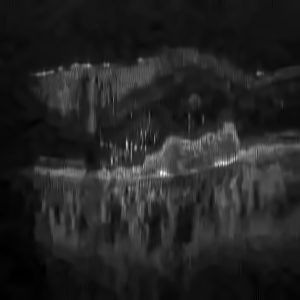

In [56]:
denoised_raw_y_arr

array([[20, 20, 18, ..., 23, 23, 23],
       [20, 20, 18, ..., 23, 23, 23],
       [20, 20, 18, ..., 23, 23, 23],
       ...,
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5]], dtype=uint8)
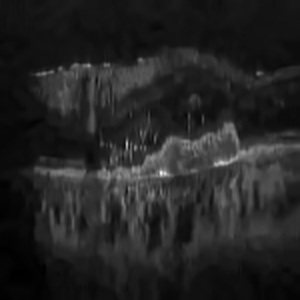

In [57]:
y_hat_bicubic

array([[20, 19, 18, ..., 23, 23, 23],
       [20, 19, 18, ..., 23, 23, 23],
       [20, 19, 18, ..., 23, 23, 23],
       ...,
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5]], dtype=uint8)
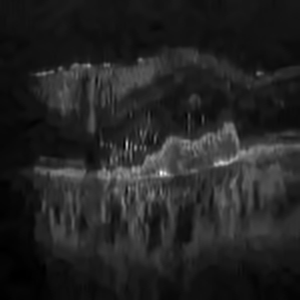

In [58]:
y_hat_lanczos

array([[20, 18, 19, ..., 23, 23, 23],
       [20, 18, 19, ..., 23, 23, 23],
       [20, 18, 19, ..., 23, 23, 23],
       ...,
       [ 1,  1,  2, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5],
       [ 1,  1,  1, ...,  5,  5,  5]], dtype=uint8)
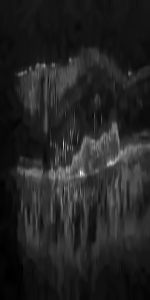

In [59]:
denoised_raw_x_arr

array([[20, 19, 19, ..., 23, 24, 23],
       [21, 20, 18, ..., 23, 24, 24],
       [20, 20, 18, ..., 23, 23, 24],
       ...,
       [ 1,  1,  1, ...,  5,  5,  6],
       [ 1,  1,  1, ...,  5,  5,  6],
       [ 1,  1,  1, ...,  5,  5,  5]], dtype=uint8)
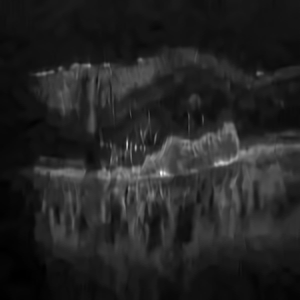

In [60]:
y_hat_opencv

array([[33, 32, 34, ..., 47, 45, 46],
       [33, 34, 34, ..., 46, 46, 46],
       [34, 34, 36, ..., 46, 46, 45],
       ...,
       [23, 20, 22, ..., 31, 17, 15],
       [22, 21, 23, ..., 30, 17, 14],
       [21, 22, 22, ..., 29, 21, 17]], dtype=uint8)
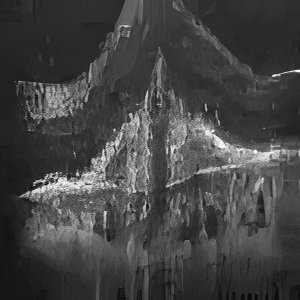

In [61]:
y_hat_esr_gan

In [67]:
len(cnrs["denoised_y_raw"]), len(cnrs["bicubic"]), len(cnrs["lanczos"]), len(cnrs["opencv"]), len(cnrs["esr_gan"])

(256, 256, 256, 256, 256)

In [68]:
len(msrs["denoised_y_raw"]), len(msrs["bicubic"]), len(msrs["lanczos"]), len(msrs["opencv"]), len(msrs["esr_gan"])

(256, 256, 256, 256, 256)

Training Dataset

In [69]:
print(f"denoised_y_raw: CNR: {np.mean(cnrs['denoised_y_raw'])}, MSR: {np.mean(msrs['denoised_y_raw'])}")
print(f"bicubic: CNR: {np.mean(cnrs['bicubic'])}, MSR: {np.mean(msrs['bicubic'])}")
print(f"lanczos: CNR: {np.mean(cnrs['lanczos'])}, MSR: {np.mean(msrs['lanczos'])}")
print(f"opencv: CNR: {np.mean(cnrs['opencv'])}, MSR: {np.mean(msrs['opencv'])}")
print(f"esr_gan: CNR: {np.mean(cnrs['esr_gan'])}, MSR: {np.mean(msrs['esr_gan'])}")

denoised_y_raw: CNR: 2.825882453369973, MSR: 1.6178229251240994
bicubic: CNR: 2.846079450881626, MSR: 1.626930981740867
lanczos: CNR: 2.843768182913367, MSR: 1.6258770044643023
opencv: CNR: 2.8501577028327194, MSR: 1.6294728338747624
esr_gan: CNR: 2.657327824346962, MSR: 1.55242134693104
